In [1]:
import scoops
import MDAnalysis as mda
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline

## Load the data
The SCOOPS workflow uses MDAnalysis to load MD data.  This example notebook uses a multiframe PDB file.  MDAnalysis can also load several other formats, e.g. `u = mda.Universe("test_psf.psf", ["test_dcd_1.dcd, "test_dcd_2.dcd"])`.  See the MDAnalysis documentation for more details.

In [2]:
u = mda.Universe("mpro_short_traj.pdb")

/Users/danielevans/Desktop/work/lau/vols_and_diheds/scoops_new/scoops/.venv/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


## Select the binding site location.
Our example protein is SARS-CoV-2 main protease.  It is a homodimer; each chain's active site has two catalytic residues.  We will define our binding site's center as the center of mass of chain A's catalytic residues.  The site's edge will be a sphere with radius 9 Angstroms.

SCOOPS divides space into a 3D grid of cubes called voxels.  The binding pocket is defined as a collection of filled voxels.  See below for a representation of this.

The volume-calculation procedure has several steps:
* Create a voxelized sphere with the correct center and radius.  This is stored as a `VoxelGrid` object.
* Remove all regions of the sphere that are occupied by protein.
  * Find the distance from each voxel in the sphere to each protein atom.
  * Define a minimum distance from each atom.  This is the atom's van der Waals radius plus a "solvent radius" parameter.  (A typical value of solvent radius of 1.09, the van der Waals radius of hydrogen.)
  * Remove voxels within an atom's minimum distance.
* Optional: remove everything from the pocket except for the largest contiguous shape.

Note that a newly created MDAnalysis Universe is initialized at the first frame of the trajectory.  Thus our notebook will find the site in the first frame.

In [3]:
# Define the binding site as a sphere.
grid_size = 1 # Side length of the voxel grid (in Angstroms)
active_site_atoms = u.select_atoms("segid PROA and (resid 41 or resid 145)")
active_site_center = active_site_atoms.center_of_mass()
sphere_voxel = scoops.volumes.generate_voxelized_sphere(9, active_site_center, grid_size)

# Remove voxels that overlap with the protein.
# FIXME can I pass a selection as `universe`?
solvent_rad = 1.09
pocket_shape = scoops.volumes.get_pocket(sphere_voxel, u, solvent_rad)

# Get the largest shape.
pocket_shape = scoops.volumes.get_largest_shape(pocket_shape)

## View the binding site.
It is important to check that the binding site looks reasonable.  To do this, we must first voxelize the protein. Then we can view the protein and the pocket with the function `show_in_jupyter`.

The controls for zooming, rotating, etc. may vary between computers.  On my Mac laptop, the controls are as follows:
* Rotate screen: click and drag.
* Zoom: pinch in/out with two fingers, or slide up/down with two fingers.
* Drag camera: press and hold shift; while holding, click and drag.

Additional notes:
* The initial viewing angle might be bad.  You'll probably need to zoom out.
* If no window shows up, you might need to downgrade a library called `ipywidgets`.  This is due to a known bug in a SOOPS dependency, as described [here](https://github.com/pyvista/pyvista/issues/3274).  Running the command `pip install ipywidgets==7.7.1` should fix the issue.
* If you are running the Jupyter notebook on a remote server, you'll need to run `import pyvista as pv` and `pv.start_xvfb()` to view the protein.  Viewing the protein remotely can have severe lag, so it should be avoided when possible.
* Alternatively, you can output the voxelized shapes to PDB files using `write_voxels_to_pdb`.  E.g. `write_voxels_to_pdb(protein_surf.surf, "protein.pdb")` and `write_voxels_to_pdb(pocket_shape, "pocket.pdb")`.
* When grid_size is small (e.g. 0.5), passing large selections to `sel_regions` can dramatically slow down the code's runtime.

In [4]:
# Uncomment the pyvista xvfb lines if running on remote server. 
#import pyvista as pv
#pv.start_xvfb()
prot_atoms = u.select_atoms("protein") # Select the protein atoms (i.e. not any solvent or ligand).
protein_surf = scoops.volumes.ProteinSurface(prot_atoms, solvent_rad=solvent_rad, grid_size=grid_size)

sel_regions={u.select_atoms("segid PROA and (resid 41 or resid 145)") : "green",
             u.select_atoms("segid PROB") : "orange"}

prot_viewer = scoops.volumes.show_in_jupyter(protein_surf, sel_regions_1=sel_regions,
                                             object_2=pocket_shape)

Widget(value="<iframe src='http://localhost:52526/index.html?ui=P_0x2a4b4bdf0_0&reconnect=auto' style='width: …

## Align the trajectory.
The SCOOPS volume calculator is very sensitive to how the trajectory is aligned.  It is not enough to align the trajectory using a global alignment; you should align using just the pocket region.  This way if the entire pocket changes location (e.g. due to domain motion), this won't impact the results.

SCOOPS includes a function to automatically align to a pocket.  It finds all atoms that border the pocket, and aligns each frame to these atoms' positions in the first frame.  It writes the aligned trajectory to a file, and returns an MDAnalysis Universe of that file.  The output file can be either PDB format or (if `psf_loc` is also provided) DCD format.

In [5]:
copy_filename = "aligned.pdb"
u_copy = scoops.volumes.align_to_pocket(protein_surf, pocket_shape, u,
                                               copy_filename, 0)

protein_in_copy = u_copy.select_atoms("protein")

/Users/danielevans/Desktop/work/lau/vols_and_diheds/scoops_new/scoops/.venv/lib/python3.10/site-packages/MDAnalysis/analysis/base.py:447: UserWarning: Reader has no dt information, set to 1.0 ps
  self.times[i] = ts.time
/Users/danielevans/Desktop/work/lau/vols_and_diheds/scoops_new/scoops/.venv/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:775: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/Users/danielevans/Desktop/work/lau/vols_and_diheds/scoops_new/scoops/.venv/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning: Found no information for attr: 'elements' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/Users/danielevans/Desktop/work/lau/vols_and_diheds/scoops_new/scoops/.venv/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
 

## Get the pocket volume of each frame.

At each frame, find the voxelized pocket shape.  Store the shape and its volume in lists.

WARNING: for long trajectories, storing the voxelized pocket shape of each frame can use too much memory.  It may be necessary to only store the calculated volumes (in cubic Angstroms) of each frame, and then re-find the voxelized surfaces for frames of interest.

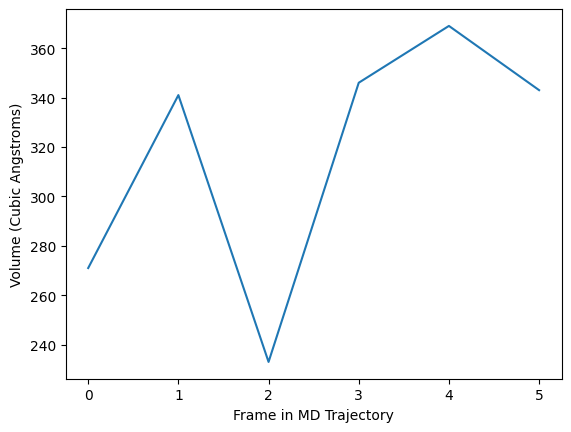

In [6]:
volumes = []
pockets = []
prots = []
for frame in u_copy.trajectory[0:6]:
    pocket_this_frame = scoops.volumes.get_pocket(sphere_voxel, protein_in_copy, solvent_rad)
    pocket_this_frame = scoops.volumes.get_largest_shape(pocket_this_frame)
    volumes.append(pocket_this_frame.volume)
    pockets.append(pocket_this_frame)

plt.plot(volumes)
plt.xlabel("Frame in MD Trajectory")
plt.ylabel("Volume (Cubic Angstroms)")
plt.show()

## Determine which atoms are on the protein surface.
This can be useful for identifying which residues might be directly involved in drug binding.  The list of surface residues can change throughout the MD data, as the protein changes conformation.  However, it is too computaitonally expensive (at least for large trajectories) to find the surface atoms for each frame.

MDAnalysis assigns an integer index to each atom.  The function `get_surface_atom_indices` returns a list of these indices for all atoms that contribute at least one voxel to the protein surface.

In [7]:
surface_atoms = scoops.volumes.get_surface_atom_indices(protein_surf)
surface_atoms

[0,
 3,
 4,
 5,
 6,
 8,
 9,
 10,
 11,
 13,
 14,
 15,
 16,
 17,
 20,
 21,
 39,
 43,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 64,
 65,
 66,
 68,
 69,
 70,
 71,
 74,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 89,
 101,
 103,
 104,
 107,
 109,
 110,
 124,
 125,
 126,
 161,
 163,
 164,
 165,
 168,
 172,
 173,
 174,
 178,
 179,
 180,
 181,
 182,
 184,
 207,
 208,
 209,
 210,
 211,
 213,
 214,
 216,
 217,
 218,
 219,
 220,
 222,
 224,
 237,
 241,
 252,
 274,
 278,
 279,
 280,
 281,
 282,
 283,
 285,
 307,
 308,
 310,
 311,
 312,
 313,
 327,
 328,
 329,
 330,
 331,
 332,
 333,
 335,
 336,
 337,
 338,
 339,
 340,
 341,
 342,
 343,
 344,
 345,
 346,
 347,
 348,
 351,
 352,
 354,
 356,
 357,
 358,
 359,
 363,
 366,
 367,
 368,
 369,
 370,
 371,
 373,
 375,
 380,
 382,
 391,
 451,
 452,
 456,
 481,
 482,
 483,
 484,
 485,
 486,
 487,
 490,
 491,
 494,
 496,
 497,
 498,
 499,
 506,
 507,
 509,
 512,
 513,
 514,
 515,
 546,
 547,
 548,
 549,
 551,
 552,
 59